In [150]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [155]:
# alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*N*/*.beams.fits')
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*S*/*.beams.fits')

allNids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesN]
allSids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesS]

Nids = np.array(list(set(allNids)))
Sids = np.array(list(set(allSids)))

Npresent = [U in Nids for U in v4N.id]
Spresent = [U in Sids for U in v4S.id]

v4N['grism'] = Npresent
v4S['grism'] = Spresent

In [156]:
alldb[['Ra', 'Rm', 'Re']] 

,Ra,Rm,Re
0,0.151500,1.313408,1.108955
1,0.138888,1.091993,1.091884
2,0.397230,3.425194,2.713480
3,0.116604,0.982116,0.878266
4,1.075130,9.345918,8.049435
5,0.974442,5.565135,5.292733
6,0.107238,0.905941,0.682890
7,0.168264,1.315997,1.076145
8,0.426246,3.525191,3.283351
9,0.298122,1.860552,1.550187


In [157]:
def Whitaker_UVJ_select(zlow, zhi):
    v4N_red = v4N.query('{} < z500 < {} and star < 0.8 and grism == True and mass > 10**10'.format(zlow, zhi))
    v4S_red = v4S.query('{} < z500 < {} and star < 0.8 and grism == True and mass > 10**10'.format(zlow, zhi))
    NUV = Color(v4N_red.restU, v4N_red.restV)
    NVJ = Color(v4N_red.restV, v4N_red.restJ)
    SUV = Color(v4S_red.restU, v4S_red.restV)
    SVJ = Color(v4S_red.restV, v4S_red.restJ)

    SQ = []
    NQ = []
    Ssf = []
    Nsf = []
    
    if zlow == 0 or zhi == 1.5:
        UVlim = 1.3
        VJlim = 1.6
    
    if zlow == 1.5 or zhi == 2.0:
        UVlim = 1.3
        VJlim = 1.5
        
    if zlow == 2.0 or zhi == 3.5:
        UVlim = 1.2
        VJlim = 1.4
    
    for i in NUV.index:
        if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>UVlim and NVJ[i]<VJlim:
            NQ.append(i)
        else:
            Nsf.append(i)

    for i in SUV.index:
        if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>UVlim and SVJ[i]<VJlim:
            SQ.append(i)
        else:
            Ssf.append(i)
    return NUV, NVJ, SUV, SVJ, NQ, SQ

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2


In [158]:
UV = []
VJ = []
for i in alldb.index:
    if alldb.field[i] == 'GSD':
        u = v4S.query('id == {}'.format(alldb.id[i])).restU.values[0]
        v = v4S.query('id == {}'.format(alldb.id[i])).restV.values[0]
        j = v4S.query('id == {}'.format(alldb.id[i])).restJ.values[0]
      
    else:
        u = v4N.query('id == {}'.format(alldb.id[i])).restU.values[0]
        v = v4N.query('id == {}'.format(alldb.id[i])).restV.values[0]
        j = v4N.query('id == {}'.format(alldb.id[i])).restJ.values[0]
    
    UV.append(Color(u, v))
    VJ.append(Color(v, j))

In [159]:
alldb['UV'] = UV
alldb['VJ'] = VJ

In [160]:
z500 = []
for i in alldb.index:
    if alldb.field[i] == 'GSD':
        z = v4S.query('id == {}'.format(alldb.id[i])).z500.values[0]
     
    else:
        z = v4N.query('id == {}'.format(alldb.id[i])).z500.values[0]
    
    z500.append(z)


In [161]:
alldb['z500'] = z500

In [162]:
W_UVJ = []


for i in alldb.index:

    if 0 < alldb.z500[i] <= 1.5:
        UVlim = 1.3
        VJlim = 1.6

    if 1.5 < alldb.z500[i] <= 2.0:
        UVlim = 1.3
        VJlim = 1.5

    if 2.0 < alldb.z500[i] <= 3.5:
        UVlim = 1.2
        VJlim = 1.4


    if alldb.UV[i]>=0.88 * alldb.VJ[i] + 0.59 and alldb.UV[i] > UVlim and alldb.VJ[i] < VJlim:
        W_UVJ.append('Q')
    else:
        W_UVJ.append('S')

In [163]:
alldb['W_UVJ'] = W_UVJ

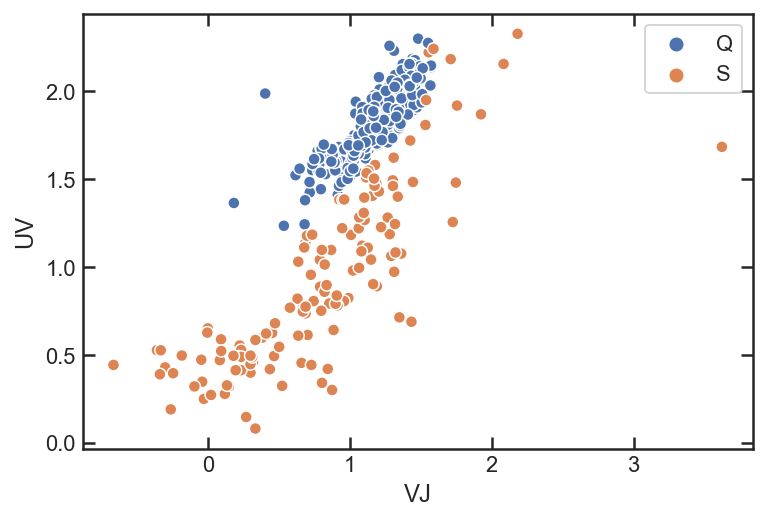

In [164]:
sea.scatterplot(alldb.VJ, alldb.UV, hue=W_UVJ)

In [165]:
alldb.to_pickle('../dataframes/fitdb/allfits_1D.pkl')


In [166]:
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:
#     if(morph_db.zgrism_hci[i][1] - morph_db.zgrism_hci[i][0]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01 and \
#     morph_db.id[i] not in bspec and morph_db.id[i] not in nog102:
        
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(-1, 2.6)

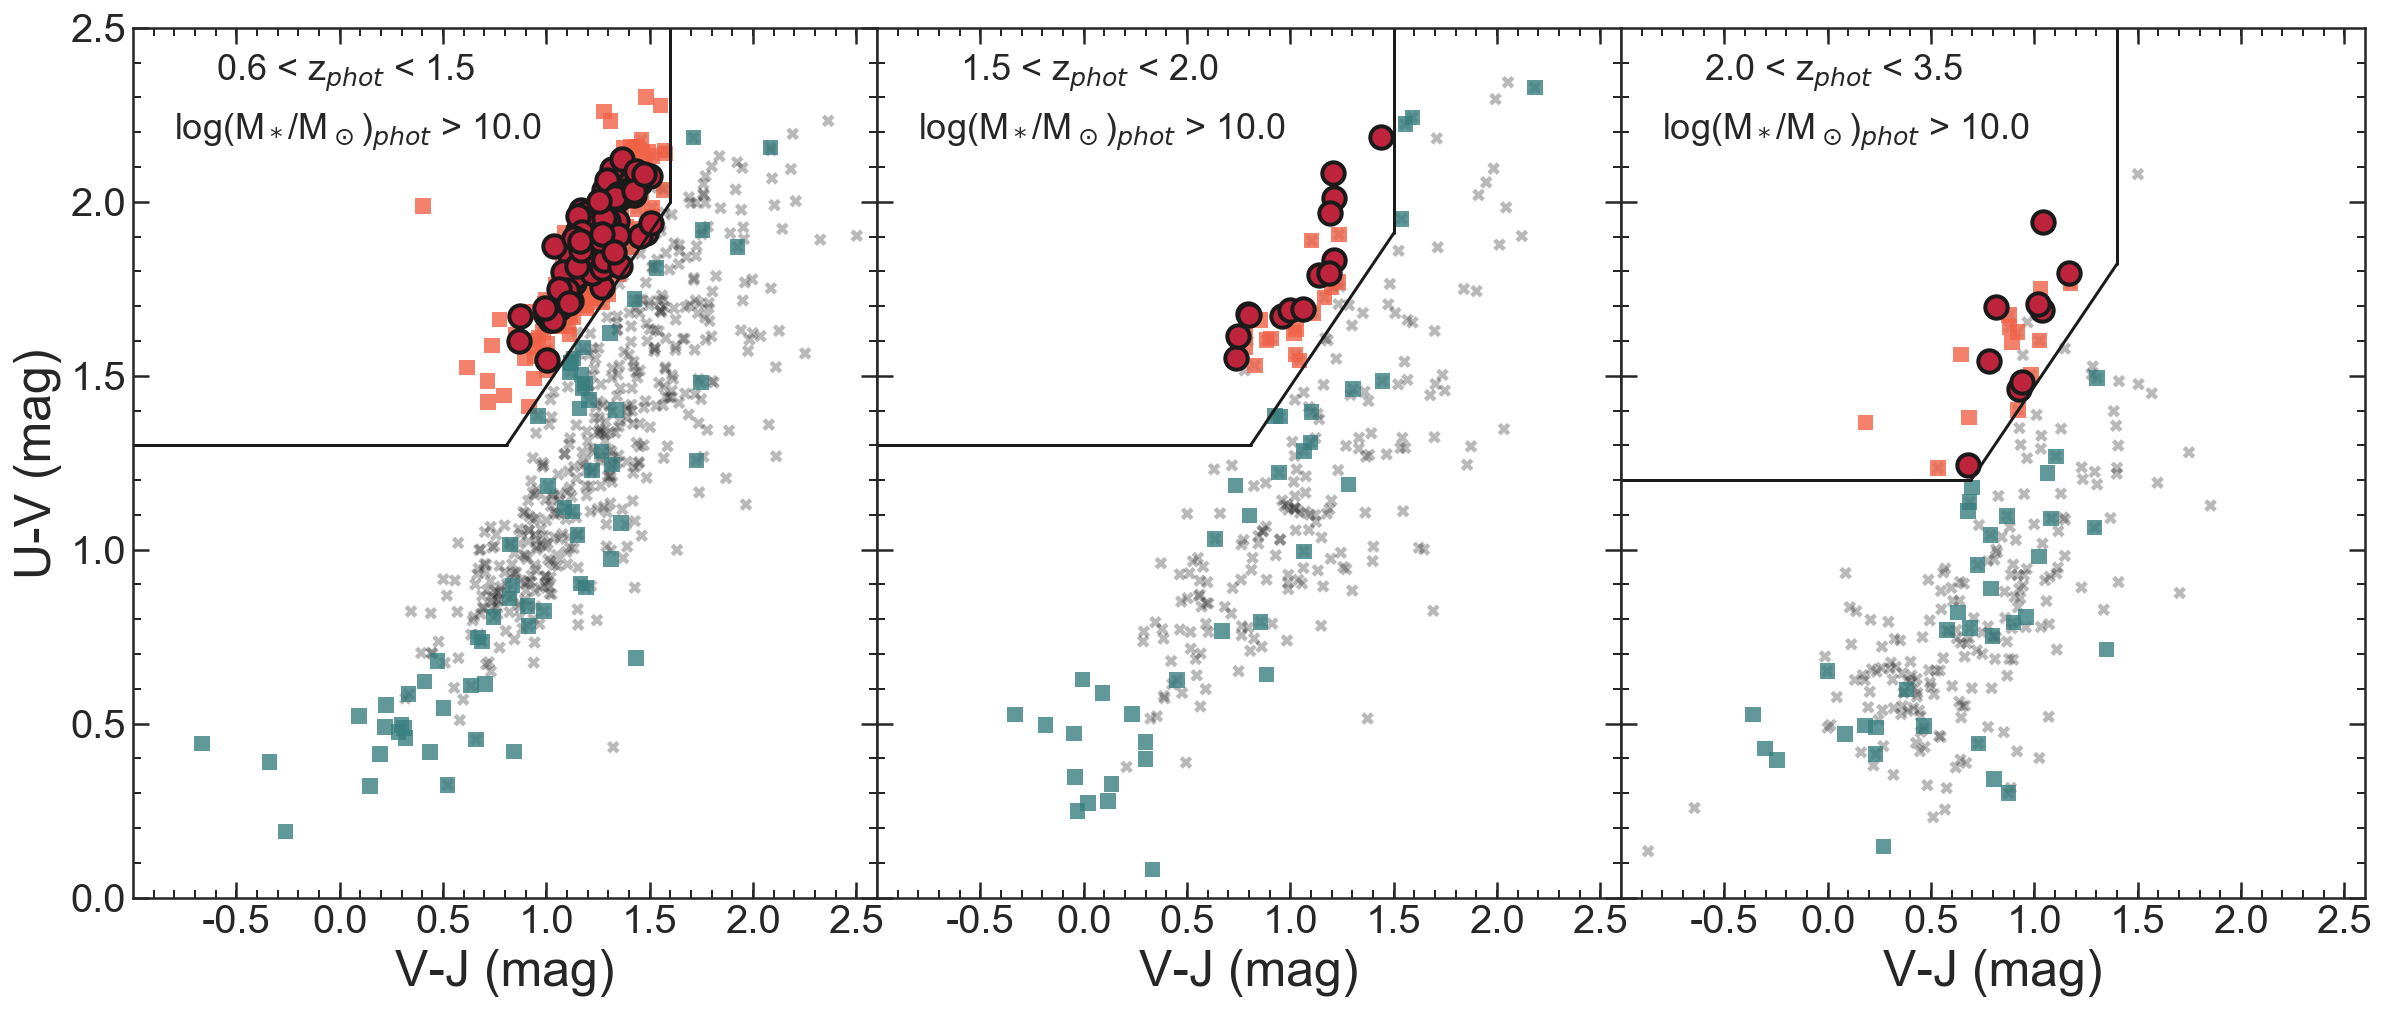

In [143]:
UVy = np.linspace(0,2.5)
VJx = np.linspace(-1,2.5)

iUVJ = interp1d(VJx, 0.88 * VJx +0.59)
invUVJ = interp1d(0.88 * VJx +0.59, VJx)

gs = gridspec.GridSpec(1,3, wspace=0)

plt.figure(figsize = [20, 8])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.set_ylim(0,2.5)
ax1.plot([-1,invUVJ(1.3)],[1.3,1.3], color = 'k')
ax1.plot([1.6,1.6],[iUVJ(1.6),2.5], color = 'k')
ax1.plot([invUVJ(1.3),1.6],[1.3,iUVJ(1.6)], color = 'k')

NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(0.6, 1.5)
ax1.scatter(SVJ, SUV,marker = 'X', s=40, color = 'k',linewidths=1, edgecolors='none', alpha = 0.3)
ax1.scatter(NVJ, NUV,marker = 'X', s=40, color = 'k',linewidths=1, edgecolors='none', alpha = 0.3)

ax1.scatter(alldb.query('W_UVJ == "Q" and 0 < z500 < 1.5').VJ, alldb.query('W_UVJ == "Q" and 0 < z500 < 1.5').UV,marker = 's', 
            s=60, color = '#F16247',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)
ax1.scatter(alldb.query('W_UVJ == "S" and 0 < z500 < 1.5').VJ, alldb.query('W_UVJ == "S" and 0 < z500 < 1.5').UV,marker = 's', 
            s=60, color = '#3A7F81',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)

ax1.scatter(mdb.query('0 < z500 < 1.5').VJ, mdb.query('0 < z500 < 1.5').UV,marker = 'o', 
            s=125, color = '#BE243B',linewidths=2, edgecolors='k', zorder= 1)

######################################
ax2.set_ylim(0,2.5)
ax2.plot([-1,invUVJ(1.3)],[1.3,1.3], color = 'k')
ax2.plot([1.5,1.5],[iUVJ(1.5),2.5], color = 'k')
ax2.plot([invUVJ(1.3),1.5],[1.3,iUVJ(1.5)], color = 'k')

NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(1.5, 2)
ax2.scatter(SVJ, SUV,marker = 'X', s=40, color = 'k',linewidths=1, edgecolors='none', alpha = 0.3)
ax2.scatter(NVJ, NUV,marker = 'X', s=40, color = 'k',linewidths=1, edgecolors='none', alpha = 0.3)

ax2.scatter(alldb.query('W_UVJ == "Q" and 1.5 < z500 < 2.0').VJ, alldb.query('W_UVJ == "Q" and 1.5 < z500 < 2.0').UV,marker = 's', 
            s=60, color = '#F16247',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)
ax2.scatter(alldb.query('W_UVJ == "S" and 1.5 < z500 < 2.0').VJ, alldb.query('W_UVJ == "S" and 1.5 < z500 < 2.0').UV,marker = 's', 
            s=60, color = '#3A7F81',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)

ax2.scatter(mdb.query('1.5 < z500 < 2.0').VJ, mdb.query('1.5 < z500 < 2.0').UV,marker = 'o', 
            s=125, color = '#BE243B',linewidths=2, edgecolors='k', zorder= 1)

############################################
ax3.set_ylim(0,2.5)
ax3.plot([-1,invUVJ(1.2)],[1.2,1.2], color = 'k')
ax3.plot([1.4,1.4],[iUVJ(1.4),2.5], color = 'k')
ax3.plot([invUVJ(1.2),1.4],[1.2,iUVJ(1.4)], color = 'k')

NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(2, 3.0)
ax3.scatter(SVJ, SUV,marker = 'X', s=40, color = 'k',linewidths=1, edgecolors='none', alpha = 0.3)
ax3.scatter(NVJ, NUV,marker = 'X', s=40, color = 'k',linewidths=0.5, edgecolors='none', alpha =0.3)

ax3.scatter(alldb.query('W_UVJ == "Q" and 2.0 < z500 < 3.5').VJ, alldb.query('W_UVJ == "Q" and 2.0 < z500 < 3.5').UV,marker = 's', 
            s=60, color = '#F16247',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)
ax3.scatter(alldb.query('W_UVJ == "S" and 2.0 < z500 < 3.5').VJ, alldb.query('W_UVJ == "S" and 2.0 < z500 < 3.5').UV,marker = 's', 
            s=60, color = '#3A7F81',linewidths=1, edgecolors='none', zorder= 1, alpha = 0.8)
ax3.scatter(mdb.query('2.0 < z500 < 3.5').VJ, mdb.query('2.0 < z500 < 3.5').UV,marker = 'o', 
            s=125, color = '#BE243B',linewidths=2, edgecolors='k', zorder= 1)


ax1.set_xlabel('V-J (mag)', fontsize=25)
ax2.set_xlabel('V-J (mag)', fontsize=25)
ax3.set_xlabel('V-J (mag)', fontsize=25)

ax1.set_ylabel('U-V (mag)', fontsize=25)

ax1.set_xticks(np.arange(-0.5,3,0.5))
ax1.set_xticklabels(np.arange(-0.5,3,0.5))
ax2.set_xticks(np.arange(-0.5,3,0.5))
ax2.set_xticklabels(np.arange(-0.5,3,0.5))
ax3.set_xticks(np.arange(-0.5,3,0.5))
ax3.set_xticklabels(np.arange(-0.5,3,0.5))

ax2.set_yticks([0,0.5,1.0,1.5,2.0])
ax2.set_yticklabels([])

ax3.set_yticks([0,0.5,1.0,1.5,2.0])
ax3.set_yticklabels([])

ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1.tick_params(axis='both', which='major', labelsize=20, length = 8)
ax2.tick_params(axis='both', which='major', labelsize=20, length = 8)
ax3.tick_params(axis='both', which='major', labelsize=20, length = 8)

ax1.text(-0.6, 2.35, '0.6 < z$_{phot}$ < 1.5', fontsize = 18)
ax1.text(-0.8, 2.18, 'log(M$_*$/M$_\odot$)$_{phot}$ > 10.0', fontsize = 18)

ax2.text(-0.6, 2.35, '1.5 < z$_{phot}$ < 2.0', fontsize = 18)
ax2.text(-0.8, 2.18, 'log(M$_*$/M$_\odot$)$_{phot}$ > 10.0', fontsize = 18)

ax3.text(-0.6, 2.35, '2.0 < z$_{phot}$ < 3.5', fontsize = 18)
ax3.text(-0.8, 2.18, 'log(M$_*$/M$_\odot$)$_{phot}$ > 10.0', fontsize = 18)

ax1.set_xlim(-1, 2.6)
ax2.set_xlim(-1, 2.6)
ax3.set_xlim(-1, 2.6)


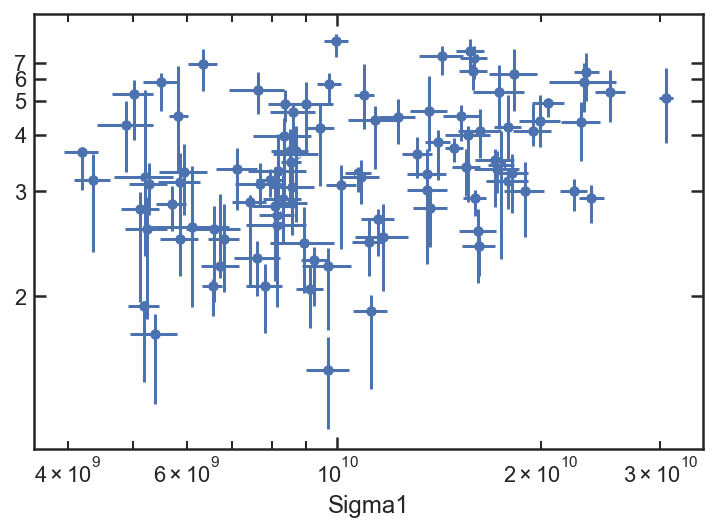

In [146]:
z50lerr = []
z50herr = []

for i in mdb.index:
#     print(mdb.field[i],mdb.id[i],mdb.zgrism[i], mdb.z_50_hdr[i])
    z50lerr.append(cosmo.lookback_time(mdb.z_50[i]).value - cosmo.lookback_time(mdb.z_50_hdr[i][0]).value)
    z50herr.append(cosmo.lookback_time(mdb.z_50_hdr[i][1]).value - cosmo.lookback_time(mdb.z_50[i]).value)
    
sea.scatterplot(mdb.Sigma1, cosmo.lookback_time(mdb.z_50.values).value)
plt.errorbar(mdb.Sigma1, cosmo.lookback_time(mdb.z_50.values).value, 
             xerr = mdb.Sigma1_sig , yerr = [z50lerr, z50herr], linestyle = 'none')

plt.yticks(cosmo.lookback_time([2,3,4,5,6,7]).value,[2,3,4,5,6,7])
plt.xscale('log')

In [149]:
mdb.query('id == 40862')

,Av,Av_hdr,Av_modality,Z,Z_hdr,Z_modality,lmass,lmass_hdr,lmass_modality,lwa,...,n_sig,mag,mag_sig,Sigma1,Sigma1_sig,UV,VJ,z500,W_UVJ,inout
2,0.454612,"[0.41118994718654833, 0.5034610756904888]",[0.0],1.513089,"[1.359821668259264, 1.5777491380769677]",[0.0],11.114971,"[11.094654468939915, 11.131499876813656]",[0.0],1.757985,...,0.029632,21.53,0.007775,7.962718e+09,3.665679e+08,1.83743,1.322951,1.341581,Q,i


In [19]:
for ID in UVJ_W_N:
    if not ID in alldb.query('field == "GND"').id.values:
        print(ID)
print('---')     
for i in mdb.query('field == "GND"').index:
    if not mdb.id[i] in UVJ_W_N:
        print(mdb.id[i])

12006.0
14355.0
17194.0
20538.0
21618.0
22184.0
22633.0
23857.0
26544.0
34130.0
35831.0
37343.0
38126.0
38225.0
14140.0
33777.0
37107.0
12543.0
15976.0
26197.0
38061.0
---
29464
18633
13191
16574
17599
19850
22363
24345
28451
29183
33775
34419
36838
37325
38102


In [8]:
for ID in UVJ_W_S:
    if not ID in alldb.query('field == "GSD"').id.values:
        print(ID)
        
print('---')     
for i in mdb.query('field == "GSD"').index:
    if not mdb.id[i] in UVJ_W_S:
        print(mdb.id[i])

18169.0
20960.0
23102.0
24148.0
24622.0
25053.0
25884.0
26914.0
27965.0
29928.0
30144.0
30152.0
35046.0
35579.0
38472.0
40985.0
42548.0
42985.0
44471.0
46275.0
46500.0
42113.0
43114.0
43683.0
42607.0
44133.0
44725.0
---
24315
24569
37828
39649
41147
42487
42615


In [9]:
GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

In [10]:
for ID in UVJ_W_N:
    if not ID in GND_all.id.values:
        print(ID)

14355.0
15901.0
21047.0
21618.0
21683.0
21896.0
22184.0
26544.0
27458.0
27714.0
32566.0
35831.0
37765.0
37955.0
35469.0
37107.0
37189.0
12543.0
22774.0
28890.0


In [11]:
for ID in UVJ_W_S:
    if not ID in GSD_all.id.values:
        print(ID)

18169.0
18642.0
19148.0
20960.0
23102.0
24148.0
24622.0
25053.0
26914.0
26915.0
30144.0
30152.0
32799.0
35046.0
35579.0
37739.0
38472.0
38786.0
44946.0
46500.0
47223.0
48631.0
26139.0
31397.0
35640.0


In [3]:
Sids = [23102,24622,25053,25884,27965,29928,40985,42985,44471,46275,42113,43114,43683,42607,44133]
Sz =   [0.664,0.680,0.631,0.666,0.619,1.090,0.748,0.733,0.732,0.717,1.615,1.890,1.888,2.269,2.140]
Nids = [12006,17194,20538,22633,23857,38225,33777,15976,26197,38061]
Nz =   [0.664,1.019,0.641,1.014,1.120,1.226,1.769,2.493,2.053,1.815]


In [7]:
from shutil import copy

for ID in Sids:
    flist = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*S*/*{}*'.format(ID))
    for f in flist:
        copy(f,'../beams/' + os.path.basename(f))

In [23]:
len(Sids)+len(Nids)

28

In [179]:
pre = 'N'
gid = Nids[9]

Gs = Gen_spec('G{}D'.format(pre), gid, 1,decontam = False)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 icat20tdq_flt.fits G102
2 icat20tiq_flt.fits G102
3 icat20tpq_flt.fits G102
4 icxt47xbq_flt.fits G102
5 icxt47xcq_flt.fits G102
6 icxt47xfq_flt.fits G102
7 icxt47xhq_flt.fits G102
8 icxt48mgq_flt.fits G102
9 icxt48mhq_flt.fits G102
10 icxt48mnq_flt.fits G102
11 icxt48mtq_flt.fits G102
12 icxt46swq_flt.fits G102
13 icxt46sxq_flt.fits G102
14 icxt46t0q_flt.fits G102
15 icxt46t2q_flt.fits G102
16 icxt49hmq_flt.fits G102
17 icxt49hnq_flt.fits G102
18 icxt49hqq_flt.fits G102
19 icxt49hsq_flt.fits G102
20 icxt50hvq_flt.fits G102
21 icxt50hwq_flt.fits G102
22 icxt50hzq_flt.fits G102
23 icxt50i1q_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))


missing g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [180]:
fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))

redshifts = []
for f in fp:
    subfield = f.split('/')[-2]
    dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
    rshift = dat.query('ID == {0}'.format(gid)).z_50.values[0]
    redshifts.append(rshift)

print(redshifts,v4N.query('id == {}'.format(gid)).z500.values[0])

[1.815447958655959, 1.815447958655959] 2.0125933840198447


No handles with labels found to put in legend.


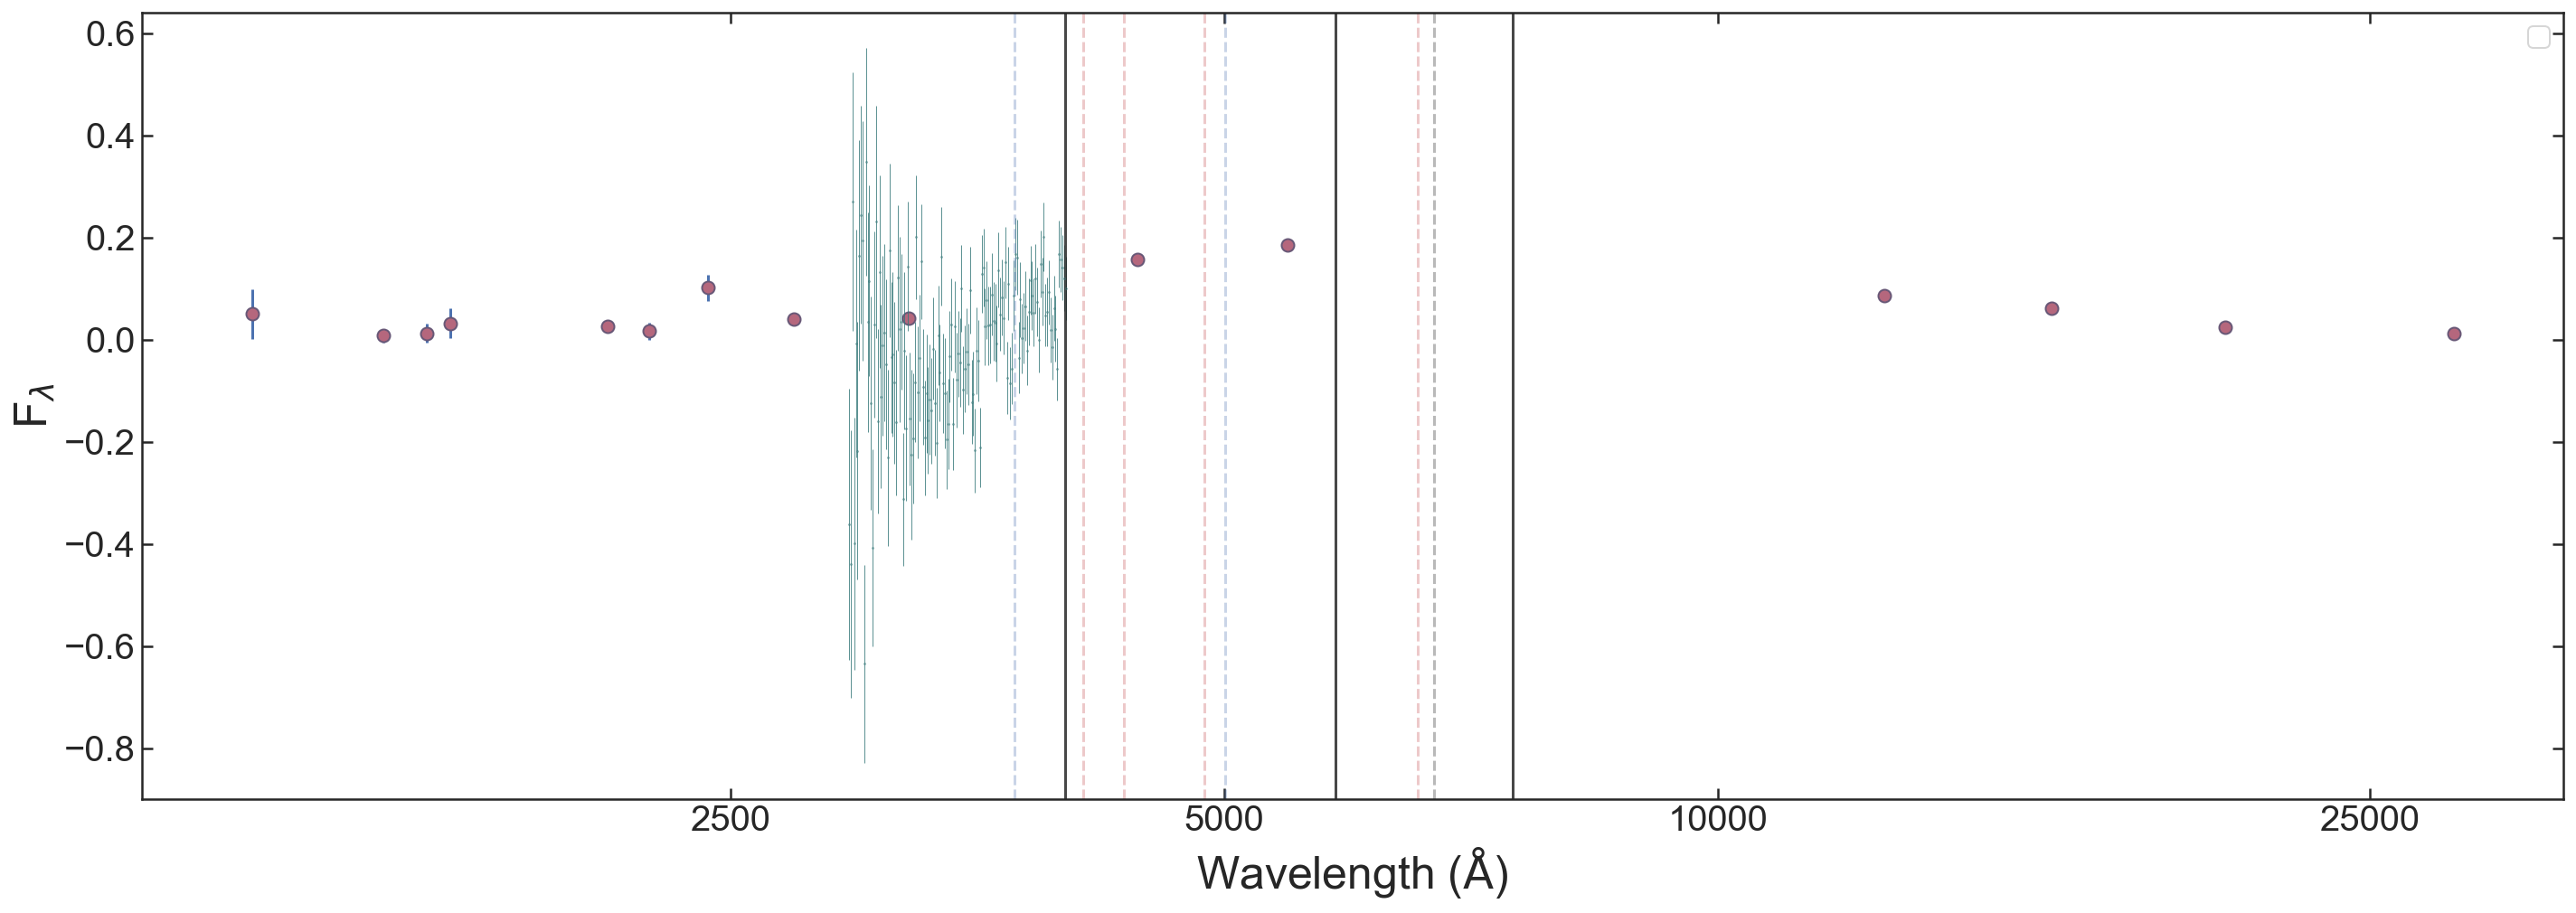

In [181]:
z =1.815
plt.figure(figsize=[24,8])

ax2 = plt.subplot()

if Gs.g102:
    ax2.errorbar(np.log10(Gs.Bwv / (1+z)),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

if Gs.g141:
    ax2.errorbar(np.log10(Gs.Rwv / (1+z)),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)


ax2.errorbar(np.log10(Gs.Pwv / (1+z)),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

# ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

ax2.set_xticks(np.log10([2500,5000,10000,25000]))
ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
ax2.legend(fontsize=15, frameon = True, loc = 1)
ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.axvline(np.log10(3727.092),linestyle='--', alpha=.3) # OII
plt.axvline(np.log10(4000), alpha=0.8, color = 'k')
plt.axvline(np.log10(5850), alpha=0.8, color = 'k')
plt.axvline(np.log10(7500), alpha=0.8, color = 'k')

plt.axvline(np.log10(4102.89),linestyle='--', alpha=.3, color = 'r')
plt.axvline(np.log10(4341.68),linestyle='--', alpha=.3, color = 'r')
plt.axvline(np.log10(4862.68),linestyle='--', alpha=.3, color = 'r')
plt.axvline(np.log10(5008.240),linestyle='--', alpha=.3)
plt.axvline(np.log10(6564.61),linestyle='--', alpha=.3, color = 'r')
plt.axvline(np.log10(6718.2),linestyle='--', alpha=.3, color = 'k')

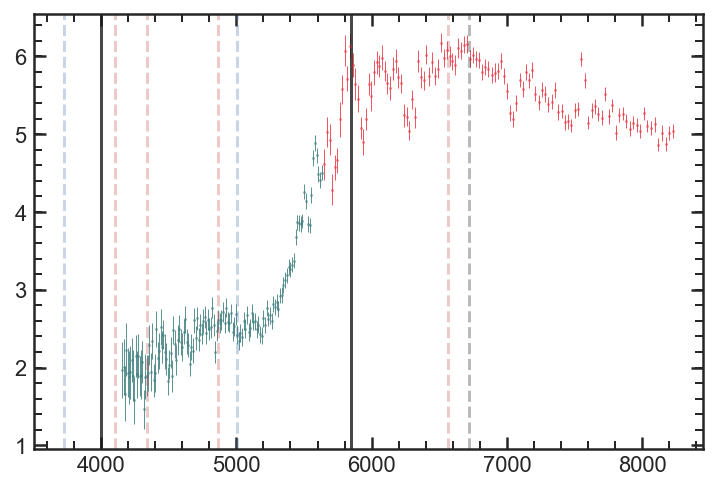

In [4]:
z=1

ax2 = plt.subplot()

if Gs.g102:
    ax2.errorbar(Gs.Bwv / (1+z),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

if Gs.g141:
    ax2.errorbar(Gs.Rwv / (1+z),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
    
plt.axvline(3727.092,linestyle='--', alpha=.3) # OII
plt.axvline(4000, alpha=0.8, color = 'k')
plt.axvline(5850, alpha=0.8, color = 'k')
# plt.axvline(7500, alpha=0.8, color = 'k')

plt.axvline(4102.89,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68,linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240,linestyle='--', alpha=.3)
plt.axvline(6564.61,linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.2,linestyle='--', alpha=.3, color = 'k')

In [30]:
pre = 'S'
for gid in Sids:

    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))

    redshifts = []
    for f in fp:
        subfield = f.split('/')[-2]
        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        rshift = dat.query('ID == {0}'.format(gid)).z_50.values[0]
        redshifts.append(rshift)

    print(redshifts,v4S.query('id == {}'.format(gid)).z500.values[0])

[5.612982903393328] 0.6644233465876154
[-99.0] 0.6805267586767949
[4.989378179748994] 0.6313877580529915
[0.6664305850786936] 0.6648542067638252
[0.6194550584263085] 0.6152853476495794
[1.090379361020816] 1.0948358824666813
[0.6041094346395653] 0.7361335185085097
[1.288824528663768, 2.056555876532665] 1.422201492313386
[0.7337969058316448] 0.7329667914724564
[0.7317234055848518] 0.732394989528634
[0.7312589443779716, 0.7095507676789674] 0.7166254343503097
[1.415603146201275, 1.615637687336545] 1.691336902173901
[1.890021608952263] 1.907459087545665
[1.887696633331398] 1.9313636914950834
[2.268636012213835, 1.944069865429583] 2.505844979296532
[1.402274502355773, 2.143803418036335, 2.143803418036335] 2.094713669247715


In [29]:
v4S.query('id == {}'.format(gid)).z500.values[0]

2.094713669247715

In [2]:
Gs = Gen_spec('GSD', 43114, 1)

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ib6o23rsq_flt.fits G141
22 ib6o23ruq_flt.fits G141
23 ib6o23ryq_flt.fits G141
24 ib6o23s0q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ib6o23rsq_flt.fits G141
22 ib6o23ruq_flt.fits G141
23 ib6o23ryq_flt.fits G141
24 ib6o23s0q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [10]:
Gs.Rfl

array([4.61217681e-18, 5.02876296e-18, 4.92615480e-18, 4.28741898e-18,
       4.57257908e-18, 4.66331920e-18, 5.18860419e-18, 5.57578571e-18,
       6.07443217e-18, 5.71461149e-18, 6.13331236e-18, 5.88485761e-18,
       5.64136230e-18, 5.45214368e-18, 5.07830821e-18, 4.90158426e-18,
       5.19089662e-18, 5.64019027e-18, 5.49006076e-18, 5.79412141e-18,
       5.92404348e-18, 5.87641189e-18, 5.98390036e-18, 5.81182164e-18,
       5.65134675e-18, 5.58807511e-18, 5.83788079e-18, 5.93640896e-18,
       5.73118420e-18, 5.65056064e-18, 5.24379792e-18, 5.22359244e-18,
       5.04338422e-18, 5.44757133e-18, 5.21720323e-18, 5.94179783e-18,
       5.72779580e-18, 5.69090759e-18, 6.01965651e-18, 5.74099185e-18,
       5.92119254e-18, 5.74604981e-18, 5.84224177e-18, 6.17256399e-18,
       5.98098266e-18, 6.08264571e-18, 6.00464638e-18, 5.93619454e-18,
       5.88710851e-18, 6.10856588e-18, 6.06847584e-18, 6.14828665e-18,
       6.15830473e-18, 5.97032056e-18, 6.01957144e-18, 5.96467338e-18,
      